In [51]:
#     API Alpaca
#     Data cleanup
#     Consumer Discretionary Monte Carlo = XLY
#     Consumer Staples Monte Carlo = XLP
#     SP500 GROWTH Monte Carlo = SGX


In [111]:
#import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [53]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')
type(APCA_API_KEY_ID)


str

In [54]:
#Use alpha vantage to get historic quotes for XLY,XLP,SGX. This goes back 20 years.

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
xly_df.head()

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.tail()

ivw_df = api.alpha_vantage.historic_quotes('IVW', adjusted=True, output_format='pandas')
#ivw_df.head()


In [55]:
xly_df.head()


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-30,116.48,117.30,115.3988,116.60,116.60,5013531.0,0.0,1.0
2020-04-29,117.03,118.21,116.3800,117.33,117.33,4998795.0,0.0,1.0
2020-04-28,116.49,116.90,114.2200,114.80,114.80,4729438.0,0.0,1.0
2020-04-27,113.40,115.09,113.2900,114.35,114.35,4118447.0,0.0,1.0
2020-04-24,111.52,112.75,110.4950,112.25,112.25,2914498.0,0.0,1.0


In [56]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

ivw_df = ivw_df['5. adjusted close']
ivw_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xly_df, xlp_df, ivw_df], axis = "columns", join = "inner")
concat_df.head()
    

,5. adjusted close,5. adjusted close,5. adjusted close
date,,,
2020-04-30,116.60,58.26,188.57
2020-04-29,117.33,58.96,188.89
2020-04-28,114.80,59.21,183.09
2020-04-27,114.35,58.88,185.34
2020-04-24,112.25,58.71,183.50


In [57]:
#print column names
print(concat_df.columns)


Index(['5. adjusted close', '5. adjusted close', '5. adjusted close'], dtype='object')


In [59]:
#Change column names to avoid confusion
columns = ['XLY close', 'XLP close', 'IVW close']
concat_df.columns = columns
concat_df.head()


,XLY close,XLP close,IVW close
date,,,
2020-04-30,116.60,58.26,188.57
2020-04-29,117.33,58.96,188.89
2020-04-28,114.80,59.21,183.09
2020-04-27,114.35,58.88,185.34
2020-04-24,112.25,58.71,183.50


In [60]:
#add another column to get daily returns of XLY
daily_returns_xly = xly_df.pct_change()
concat_df['XLY_return']= daily_returns_xly 

#add another column to get daily returns of XLP
daily_returns_xlp = xlp_df.pct_change()
concat_df['XLP_return']= daily_returns_xlp 

#add another column to get daily returns of SGX
daily_returns_ivw = ivw_df.pct_change()
concat_df['IVW_return']= daily_returns_ivw 

concat_df.head()

,XLY close,XLP close,IVW close,XLY_return,XLP_return,IVW_return
date,,,,,,
2020-04-30,116.60,58.26,188.57,NaN,NaN,NaN
2020-04-29,117.33,58.96,188.89,0.006261,0.012015,0.001697
2020-04-28,114.80,59.21,183.09,-0.021563,0.004240,-0.030706
2020-04-27,114.35,58.88,185.34,-0.003920,-0.005573,0.012289
2020-04-24,112.25,58.71,183.50,-0.018365,-0.002887,-0.009928


In [61]:
#check for nulls

concat_df.isnull().sum()

XLY close     0
XLP close     0
IVW close     0
XLY_return    1
XLP_return    1
IVW_return    1
dtype: int64

In [62]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLY close     0
XLP close     0
IVW close     0
XLY_return    0
XLP_return    0
IVW_return    0
dtype: int64

In [63]:
# Checking for duplicate rows
concat_df.duplicated()

date
2020-04-29    False
2020-04-28    False
2020-04-27    False
2020-04-24    False
2020-04-23    False
              ...  
2000-06-02    False
2000-06-01    False
2000-05-31    False
2000-05-30    False
2000-05-26    False
Length: 5012, dtype: bool

In [64]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [65]:
concat_df.sort_index(inplace=True, ascending=True)

In [66]:
concat_df.head()

,XLY close,XLP close,IVW close,XLY_return,XLP_return,IVW_return
date,,,,,,
2000-05-26,20.4125,15.2972,61.6055,-0.007551,0.005793,-0.039843
2000-05-30,20.5678,15.2091,64.1619,-0.023237,0.009612,0.000000
2000-05-31,21.0571,15.0643,64.1619,-0.007326,-0.002503,-0.012298
2000-06-01,21.2125,15.1021,64.9608,-0.026726,0.035824,-0.031863
2000-06-02,21.7950,14.5798,67.0988,0.005374,0.001298,0.005015


In [116]:
#calculate value of standard deviation of daily returns
#use the std function to calculate the standard deviation of daily returns for XLY, XLP, & SGX

std_xly_daily_returns = concat_df['XLY_return'].std()
std_xly_daily_returns

std_xlp_daily_returns = concat_df['XLP_return'].std()
std_xlp_daily_returns

std_ivw_daily_returns = concat_df['IVW_return'].std()
std_ivw_daily_returns

0.013475656721798818

In [117]:
#calculate average of daily returns
avg_xly_daily_returns = concat_df['XLY_return'].mean()
avg_xly_daily_returns

avg_xlp_daily_returns = concat_df['XLP_return'].mean()
avg_xlp_daily_returns

avg_ivw_daily_returns = concat_df['IVW_return'].mean()
avg_ivw_daily_returns

-0.00013369405070561257

In [118]:
#Check datatypes

concat_df.dtypes

XLY close     float64
XLP close     float64
IVW close     float64
XLY_return    float64
XLP_return    float64
IVW_return    float64
dtype: object

In [70]:
#check counts
concat_df.count()

XLY close     5012
XLP close     5012
IVW close     5012
XLY_return    5012
XLP_return    5012
IVW_return    5012
dtype: int64

In [119]:
#use describe to explore data
concat_df.describe()

,XLY close,XLP close,IVW close,XLY_return,XLP_return,IVW_return
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,46.982950,28.702122,77.440777,-0.000248,-0.000221,-0.000134
std,30.601988,14.758473,42.790004,0.014131,0.009531,0.013476
min,13.621800,11.666100,30.552700,-0.104402,-0.083707,-0.199221
25%,24.543775,16.248025,46.185200,-0.007065,-0.005110,-0.005776
50%,31.372950,20.820100,57.294800,-0.000822,-0.000443,-0.000696
75%,69.966600,42.688300,104.505350,0.005764,0.004201,0.004683
max,131.682600,64.409400,209.913000,0.145063,0.103699,0.313908


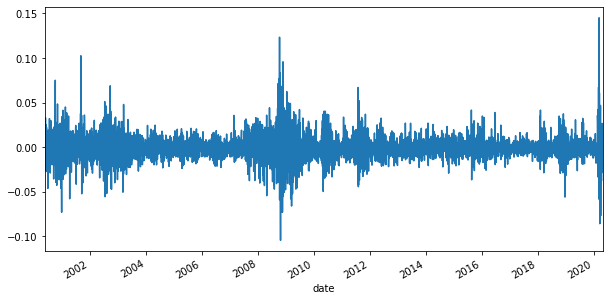

In [120]:
#plot daily returns of XLY

concat_df['XLY_return'].plot(figsize=(10,5))

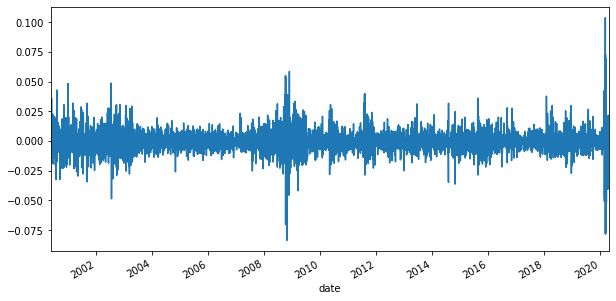

In [121]:
#plot daily returns of XLP

concat_df['XLP_return'].plot(figsize=(10,5))

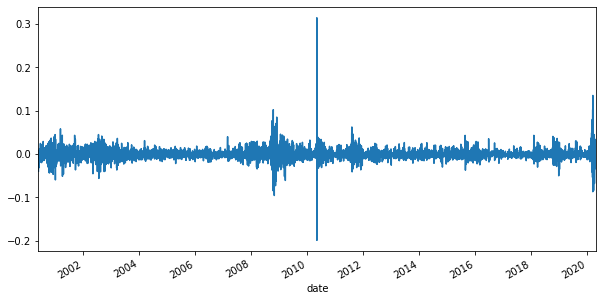

In [122]:
#plot daily returns of IVW

concat_df['IVW_return'].plot(figsize=(10,5))

In [123]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xly = (1 + concat_df['XLY_return']).cumprod()
cumulative_returns_xlp = (1 + concat_df['XLP_return']).cumprod()
cumulative_returns_ivw = (1 + concat_df['IVW_return']).cumprod()

cumulative_returns_xly.head()

date
2000-05-26    0.992449
2000-05-30    0.969388
2000-05-31    0.962286
2000-06-01    0.936568
2000-06-02    0.941601
Name: XLY_return, dtype: float64

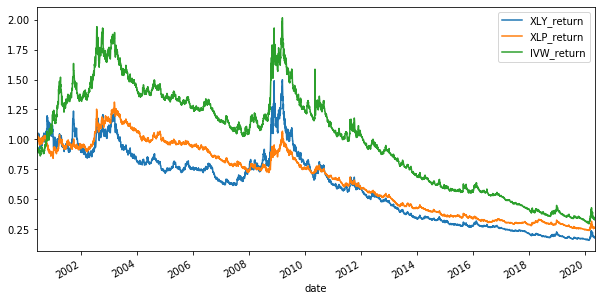

In [124]:
#plot cumulative returns

cumulative_returns_xly.plot(figsize=(10,5), legend=True)
cumulative_returns_xlp.plot(figsize=(10,5), legend=True)
cumulative_returns_ivw.plot(figsize=(10,5), legend=True)

In [88]:
#need to check on dividend

In [128]:
# Calculate Sharpe Ratios for the sectors

XLY_sharpe_ratio = (concat_df['XLY_return'].mean() * 252) / (concat_df['XLY_return'].std() * np.sqrt(252))

XLP_sharpe_ratio = (concat_df['XLP_return'].mean() * 252) / (concat_df['XLP_return'].std() * np.sqrt(252))

IVW_sharpe_ratio = (concat_df['IVW_return'].mean() * 252) / (concat_df['IVW_return'].std() * np.sqrt(252))

print(f" XLY: {XLY_sharpe_ratio}, XLP: {XLP_sharpe_ratio}, IVW:{IVW_sharpe_ratio}")




 XLY: -0.2788917981769577, XLP: -0.36879157052207795, IVW:-0.15749341968486713


In [ ]:
#BETA CALCULATION XLY and SPY

# Calculate covariance of XLK vs. S&P 500
covariance = returns_only_df['XLY_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of XLY
XLY_beta = covariance / variance
XLY_beta

In [131]:
concat_df.head()

,XLY close,XLP close,IVW close,XLY_return,XLP_return,IVW_return
date,,,,,,
2000-05-26,20.4125,15.2972,61.6055,-0.007551,0.005793,-0.039843
2000-05-30,20.5678,15.2091,64.1619,-0.023237,0.009612,0.000000
2000-05-31,21.0571,15.0643,64.1619,-0.007326,-0.002503,-0.012298
2000-06-01,21.2125,15.1021,64.9608,-0.026726,0.035824,-0.031863
2000-06-02,21.7950,14.5798,67.0988,0.005374,0.001298,0.005015


In [148]:
#START MONTE CARLO ANALYSIS (XLY)
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLY from DataFrame

num_trading_days = 30
xly_last_price = concat_df['XLY close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLY_df = pd.DataFrame()


In [149]:
## Run the simulation `1000` times for XLY
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLY
    simulated_XLY_prices = [xly_last_price]
    simulated_XLY_prices

    # Simulate the returns for 504 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLY_prices[-1] * (1 + np.random.normal(avg_xly_daily_returns, std_xly_daily_returns))
        # Append the simulated price to the list
        simulated_XLY_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLY_df[f"Simulation {n+1}"] = pd.Series(simulated_XLY_prices)

simulated_prices_XLY_df.head()




,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,...,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000,117.330000
1,118.059831,121.234817,122.590493,114.331834,118.758117,117.903468,118.513143,117.615733,115.637605,118.960629,...,116.347225,116.819745,115.375639,117.284816,116.333155,117.825762,119.518188,118.793470,116.091219,116.398323
2,118.435155,120.832077,122.440278,112.478645,118.847067,117.823320,121.899500,118.245430,113.089394,117.284516,...,116.510825,116.769905,118.083497,117.513467,115.772630,118.196630,119.921964,117.283175,117.040504,117.451214
3,118.272797,122.589691,120.766236,112.935258,116.253446,118.876345,123.242153,117.958402,114.239743,118.240565,...,113.939966,119.388577,118.683070,120.737871,113.513627,116.714937,120.283014,119.834436,115.645815,119.025740
4,120.083734,121.912624,119.427742,113.245587,113.855110,118.047998,124.506589,120.223265,112.697270,116.561584,...,113.081060,119.863247,119.147812,122.514960,114.419481,119.852115,120.570448,118.122758,115.827604,119.979070


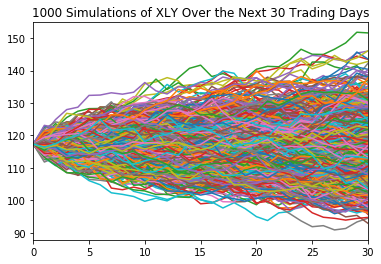

In [150]:
#plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLY Over the Next 30 Trading Days"
simulated_prices_XLY_df.plot(legend=None, title=plot_title)

In [156]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_XLY = simulated_prices_XLY_df.iloc[-1, :]
simulated_ending_prices_XLY.head()

Simulation 1    107.315309
Simulation 2    133.375558
Simulation 3    104.039757
Simulation 4    108.207111
Simulation 5    112.661219
Name: 30, dtype: float64

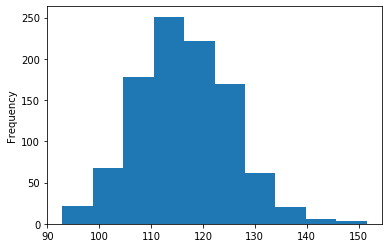

In [152]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLY.plot(kind='hist')

In [153]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLY.quantile(q=[0.025, 0.975])
confidence_interval

0.025     99.797809
0.975    134.579568
Name: 30, dtype: float64

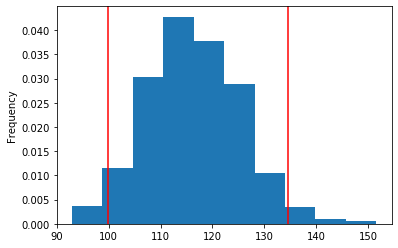

In [154]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLY.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [157]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - xly_last_price) / xly_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - xly_last_price) / xly_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in XLB"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in XLB over the next 30 trading days will end within in the range of $8505.74 and $11470.18


In [147]:
#START MONTE CARLO ANALYSIS XLP

# Calculate the mean of daily returns for XLP
avg_daily_return_xlp = concat_df.mean()['XLP_return']
print(f"The average daily return of XLP is {avg_daily_return_xlp}")

The average daily return of XLP is -0.00022141980385550423


In [158]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLP from DataFrame

num_trading_days = 30
xlp_last_price = concat_df['XLP close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLP_df = pd.DataFrame()

In [160]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLP
    simulated_XLP_prices = [xlp_last_price]
    simulated_XLP_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLP_prices[-1] * (1 + np.random.normal(avg_daily_return_xlp, std_xlp_daily_returns))
        # Append the simulated price to the list
        simulated_XLP_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLP_df[f"Simulation {n+1}"] = pd.Series(simulated_XLP_prices)

simulated_prices_XLP_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,...,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000,58.960000
1,58.923447,58.452091,58.755932,59.427341,58.840890,59.061110,59.221410,59.385220,58.464658,59.106479,...,58.516743,59.656612,58.235554,58.911292,58.497401,59.731767,59.307974,58.103235,58.433572,59.464004
2,58.974318,58.686329,59.150516,59.015469,58.725150,58.834974,58.613855,59.219466,57.871303,58.620849,...,57.753892,59.223893,58.890411,57.701608,59.089988,59.320773,59.249652,57.901233,59.894570,59.476746
3,59.050505,57.970562,59.236891,58.589883,59.676402,58.831939,59.941029,60.404366,58.546161,58.725639,...,56.917394,59.496596,58.454792,56.960402,60.225637,58.985737,59.200467,57.913378,59.506343,58.791670
4,59.121544,57.997747,59.694991,58.545743,60.407420,59.444700,59.537118,60.854660,59.781359,59.154465,...,57.678990,59.505247,58.058796,57.443410,60.106268,60.203141,59.656774,57.982676,58.789332,59.479091


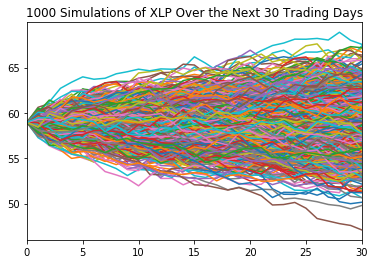

In [161]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLP Over the Next 30 Trading Days"
simulated_prices_XLP_df.plot(legend=None, title=plot_title)

In [162]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_XLP = simulated_prices_XLP_df.iloc[-1, :]
simulated_ending_prices_XLP.head()

Simulation 1    56.305733
Simulation 2    60.934360
Simulation 3    54.019659
Simulation 4    56.754873
Simulation 5    58.099661
Name: 30, dtype: float64

In [ ]:
#CHART EQUAL WEIGHTED PORTFOLIO VS OPTIMIZED WEIGHTS PORTFOLIO


